This notebook processes and integrates demographic and spatial data for Barcelona. 

The goal is to spatially disaggregate population data and assign it to the residential
buildings of OSM.

---
Author: Jordi Grau Escolano


# 1. Load data

In [1]:
import random
import sys
from pathlib import Path as PathLib
import osmnx as ox
import geopandas as gpd
import pandas as pd
from shapely import wkt
import matplotlib.pyplot as plt
import contextily as ctx

# Add project root to path
project_root = PathLib().resolve().parents[0]
sys.path.insert(0, str(project_root))

ROOT = "../"
from paths import *

In [2]:
# Load INE population of Barcelona
ine_pop_file = f'{ROOT}/{RAW_INE}/ine_census_section_population.csv'
df_pop = pd.read_csv(ine_pop_file, dtype={'census_section':str})
df_pop.set_index('census_section', inplace=True)
print(f"Size df: {df_pop.shape}")
print(df_pop.head(2))

# Load INE census seccions .shp
print("--------------------------------")
shp_file = f'{ROOT}/{RAW_INE}//seccionado_2022/SECC_CE_20220101.shp'
census_sections = gpd.read_file(shp_file)
# Filter Barcelona polygons
census_sections = census_sections[(census_sections['NPRO'] == 'Barcelona') & (census_sections['CMUN'] == '019')]
census_sections = census_sections[['CUSEC', 'geometry']]
census_sections.rename(columns={'CUSEC': 'census_sections'}, inplace=True)
census_sections.set_index('census_sections', inplace=True)
print(census_sections.head(2))

# Load OSM buildings
print("--------------------------------\n")
file = f'{ROOT}/{RAW_OSM}/Barcelona_Barcelona_Catalunya_España_residential_buildings.csv'
df_buildings = pd.read_csv(file)
df_buildings['geometry'] = df_buildings['geometry'].apply(wkt.loads)
df_buildings = gpd.GeoDataFrame(
    df_buildings, geometry=df_buildings['geometry'], crs='EPSG:25831')
df_buildings.to_crs('EPSG:25830', inplace=True)

print(f"Buildings: {df_buildings['building'].unique()}")
print(f"Amenities: {df_buildings['amenity'].unique()}")
print(df_buildings.head(2))

Size df: (17088, 3)
               sex    age  population
census_section                       
0801901001       f    0-9          64
0801901001       f  10-19          49
--------------------------------
                                                          geometry
census_sections                                                   
0801901001       POLYGON ((933150.061 4593307.551, 933099.968 4...
0801901002       POLYGON ((932835.836 4593746.927, 932844.285 4...
--------------------------------

Buildings: ['apartments' 'detached' 'dormitory' 'farm' 'farm_auxiliary' 'house'
 'parish' 'residential' 'semidetached_house' 'yes' 'yes;apartments' nan]
Amenities: [nan 'aparthotel' 'apartments' 'dormitory']
  element          id    building amenity                  street housenumber  \
0    node  3659740019  apartments     NaN  Plaça d'Alfons el Savi           6   
1    node  3813640450  apartments     NaN      Carrer de Sardenya         306   

   postcode                              

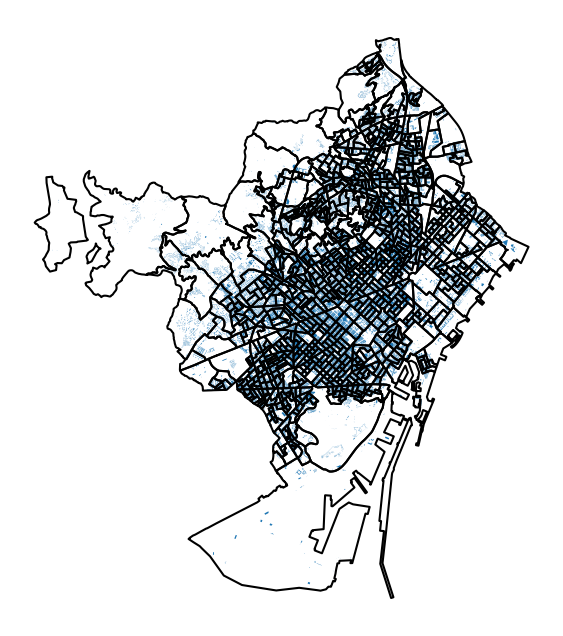

In [ ]:
# Plot census sections and buildings
fig, ax = plt.subplots(1,1, figsize=(8,8))

census_sections.boundary.plot(ax=ax, color='black', linewidth=0.5)
df_buildings.plot(ax=ax, markersize=3)
ax.axis('off')
plt.show()

In [4]:
# Load OSM bike graph
location = 'Barcelona, Barcelona, Catalunya, España'
G = ox.graph_from_place(location, network_type='bike', simplify=True, retain_all=False)
G = ox.project_graph(G)

# 2. Population indexes

In [5]:
# Total census section population 
df_pop_cs = df_pop.reset_index().groupby('census_section')['population'].sum()
df_pop_cs.head(2)

census_section
0801901001    1272
0801901002    1325
Name: population, dtype: int64

## 2.1. Sex percentage

Compute female and male percentages for each census section.

In [6]:
# Total census section population
df_pop['total_section_population'] = df_pop.groupby('census_section')['population'].transform('sum')

# Calculate population by sex per census section and percentage
df_sex_total = (
    df_pop.groupby(['census_section', 'sex'])['population']
    .sum()
    .reset_index()
)
df_sex_total['percentage'] = (
    df_sex_total.groupby('census_section')['population']
    .transform(lambda x: round((x / x.sum()) * 100, 1))
)

# Pivot to wide format for percentages by sex
df_sex = (
    df_sex_total.pivot(index='census_section', columns='sex', values='percentage')
    .fillna(0)  # Fill missing values with 0
)
df_sex.head(2)

sex,f,m
census_section,,
0801901001,45.8,54.2
0801901002,47.5,52.5


## 2.2. Age group percentage

Compute the population percentage of each age group across census sections.

In [7]:
# Calculate total population for each census section
df_age = df_pop.reset_index().groupby(['census_section', 'age'])['population'].sum().reset_index()
df_age['total_section_population'] = df_age.groupby('census_section')['population'].transform('sum')

# Calculate percentage for each age group
df_age['age_percentage'] = round((df_age['population'] / df_age['total_section_population']) * 100, 1)

df_age = df_age.pivot(index='census_section', columns='age', values='age_percentage').reset_index()
df_age.set_index('census_section', inplace=True)
df_age.head(2)

age,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70+
census_section,,,,,,,,
0801901001,9.3,6.7,16.1,22.8,16.2,12.6,6.8,9.6
0801901002,7.6,6.3,23.8,23.1,15.8,10.1,6.6,6.5


# 3. Intersecting OSM buildings with census sections

Distribute people of the census sections across the residential buildings inside them.

In [16]:
# Merge datasets to add sex and age percentages to the census sections
census_sections_pop = pd.merge(census_sections, df_sex, left_index=True, right_index=True)
census_sections_pop = pd.merge(census_sections_pop, df_age, left_index=True, right_index=True)
census_sections_pop = pd.merge(census_sections_pop, df_pop_cs, left_index=True, right_index=True)

# Find the census sections in which the buildings are
df_buildings_pop = gpd.sjoin(df_buildings[['id', 'geometry']], census_sections_pop, how='left', predicate='within')
df_buildings_pop.rename(columns={'census_sections': 'census_section'}, inplace=True)
df_buildings_pop.head(2)

,id,geometry,census_section,f,m,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70+,population
0,3659740019,POINT (931775.627 4597343.548),0801907007,52.3,47.7,6.9,7.3,12.8,14.5,17.2,15.1,9.6,16.6,1208.0
1,3813640450,POINT (932630.642 4596375.585),0801902051,53.0,47.0,5.5,6.5,17.2,22.1,14.4,12.7,10.2,11.3,1775.0


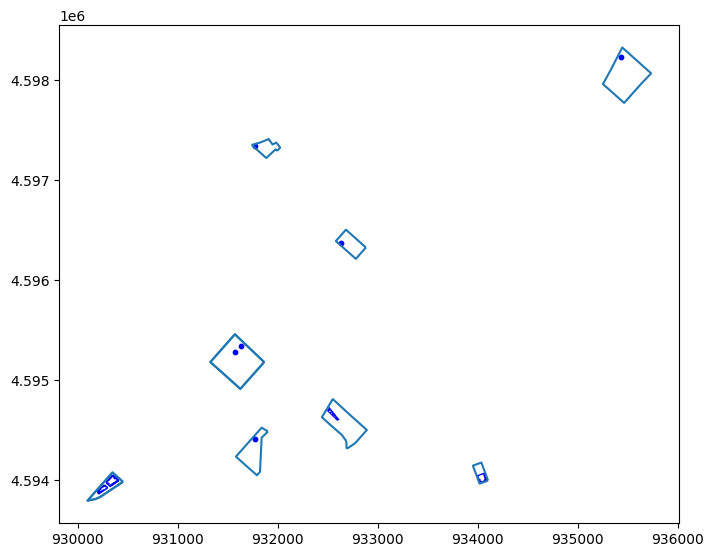

In [19]:
# Plot a few buildings and their census section to check the assignment
fig, ax = plt.subplots(1,1, figsize=(8,8))
for i in range(10):
    df_buildings_pop.iloc[[i]].plot(ax=ax, color='blue', markersize=10)
    selected_cs = df_buildings_pop.iloc[i]['census_section']
    census_sections[census_sections.index == selected_cs].boundary.plot(ax=ax)
plt.show()

In [20]:
# Calculate each building's share of its census section's population

# Calculate the total number of buildings in each census section
building_counts = df_buildings_pop.groupby('census_section').size().reset_index(name='total_buildings')
df_buildings_pop = df_buildings_pop.merge(building_counts, on='census_section')

# Calculate 1 divided by the total number of buildings
df_buildings_pop['pop_frac'] = (1 / df_buildings_pop['total_buildings'])
df_buildings_pop.drop(['total_buildings'], axis=1, inplace=True)
df_buildings_pop.rename(columns={'id': 'building_id'}, inplace=True)
df_buildings_pop['people'] = df_buildings_pop['population'] * df_buildings_pop['pop_frac']
# df_buildings_pop.drop(['population', 'pop_frac'], axis=1, inplace=True)
df_buildings_pop.head(2)

,building_id,geometry,census_section,f,m,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70+,population,pop_frac,people
0,3659740019,POINT (931775.627 4597343.548),0801907007,52.3,47.7,6.9,7.3,12.8,14.5,17.2,15.1,9.6,16.6,1208.0,0.025000,30.200000
1,3813640450,POINT (932630.642 4596375.585),0801902051,53.0,47.0,5.5,6.5,17.2,22.1,14.4,12.7,10.2,11.3,1775.0,0.011111,19.722222


In [21]:
# Check buildings with more people
df_buildings_pop.sort_values('people').head(5)

,building_id,geometry,census_section,f,m,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70+,population,pop_frac,people
39878,663862975,"POLYGON ((932245.106 4602031.176, 932245.525 4...",0801908109,49.5,50.5,9.5,12.8,11.3,13.0,15.4,16.8,11.1,10.1,956.0,0.003115,2.978193
39877,663862962,"POLYGON ((932291.328 4602075.315, 932296.348 4...",0801908109,49.5,50.5,9.5,12.8,11.3,13.0,15.4,16.8,11.1,10.1,956.0,0.003115,2.978193
39901,666124209,"POLYGON ((932129.761 4602127.118, 932133.65 46...",0801908109,49.5,50.5,9.5,12.8,11.3,13.0,15.4,16.8,11.1,10.1,956.0,0.003115,2.978193
39900,666124207,"POLYGON ((932127.04 4601845.073, 932123.877 46...",0801908109,49.5,50.5,9.5,12.8,11.3,13.0,15.4,16.8,11.1,10.1,956.0,0.003115,2.978193
39899,663872058,"POLYGON ((932313.696 4602254.323, 932316.228 4...",0801908109,49.5,50.5,9.5,12.8,11.3,13.0,15.4,16.8,11.1,10.1,956.0,0.003115,2.978193


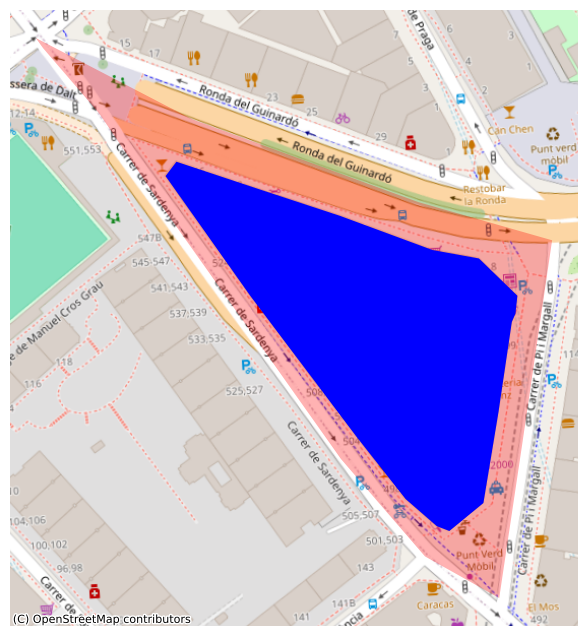

In [ ]:
# Plot building with the highest number of people. It seems to be a OSM error of not dividing 
# the block into several building polygons
fix, ax = plt.subplots(1,1, figsize=(8,8))

# census_sections.boundary.plot(ax=ax)
census_sections[census_sections.index == '0801907018'].plot(ax=ax, color='red', alpha=0.3)
df_buildings_pop[df_buildings_pop['building_id'] == 367408617].plot(ax=ax, color='blue')

# Add OSM basemap
ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik,  # OSM tiles
    crs=census_sections.crs.to_string(),       # Match CRS of your GeoDataFrame
)

ax.set_axis_off()
plt.show()

# 4. Intersection node buffers with buildings (and census sections)

Let's assign the building distributed people to the graph nodes. 
To decide which building should be considered for each node, configurable buffers around each node
are defined.

In [26]:
# Define node buffers
BUFFER_SIZE = 300

nodes, _ = ox.graph_to_gdfs(G)
nodes = nodes.to_crs("EPSG:25830")
nodes['geometry'] = nodes.buffer(BUFFER_SIZE)
gdf_nodes = nodes[['geometry']]
gdf_nodes.index.name = 'nodes_id'
gdf_nodes.index = gdf_nodes.index.astype(int)

In [42]:
# Prepare dataframes to find the buildings inside of each node buffer
gdf_buildings_pop = df_buildings_pop

# Prepare spatial index to do the spatial "within"
gdf_buildings_pop.sindex
gdf_nodes.sindex

# buildings within node polygons
joined = gpd.sjoin(
    gdf_buildings_pop, 
    gdf_nodes, 
    how='left', 
    predicate='within')

# change order of columns 
cols = list(joined.columns)
joined = joined[[cols[-1]] + cols[:-1]]
joined = joined.rename(columns={"nodes_id": "node_id"})
joined.sort_values('node_id', inplace=True)
joined = joined.drop_duplicates()

joined.head(2)

,node_id,building_id,geometry,census_section,f,m,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70+,population,pop_frac,people
36716,13019203.0,1310807054,"POLYGON ((930414.061 4593298.159, 930415.379 4...",0801903047,50.6,49.4,6.6,6.3,13.9,21.4,17.0,13.2,11.7,9.9,1673.0,0.012346,20.654321
5955,13019203.0,14723312,"POLYGON ((930735.662 4593387.994, 930731.666 4...",0801902149,50.6,49.4,7.6,8.0,14.6,17.9,17.0,14.5,11.3,9.2,1778.0,0.013514,24.027027


/tmp/ipykernel_28932/493992799.py:15: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


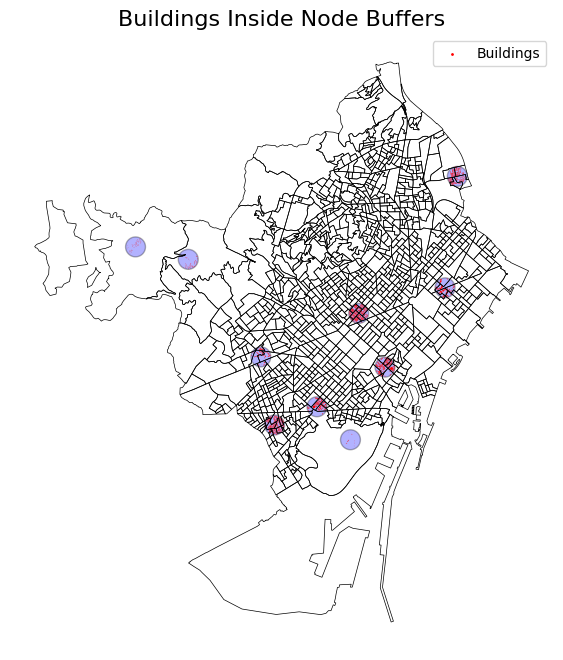

In [45]:
# Make sure the buildings are assigned to the correct node

# Get the first 5 nodes and their corresponding buildings
random_nodes = random.sample(list(buildings_in_node.keys()), 10)
nodes_to_plot = gdf_nodes.loc[random_nodes]
buildings_to_plot = gdf_buildings_pop[gdf_buildings_pop['building_id'].isin(
    [building for node in random_nodes for building in buildings_in_node[node]])]

# Plot the nodes and the buildings
fig, ax = plt.subplots(figsize=(8, 8))
nodes_to_plot.plot(ax=ax, color='blue', alpha=0.3, edgecolor='black', label='Node Buffers')
buildings_to_plot.plot(ax=ax, color='red', markersize=1, label='Buildings')
census_sections.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5, alpha=1)
ax.set_title("Buildings Inside Node Buffers", fontsize=16)
ax.legend()
ax.axis('off')
plt.show()


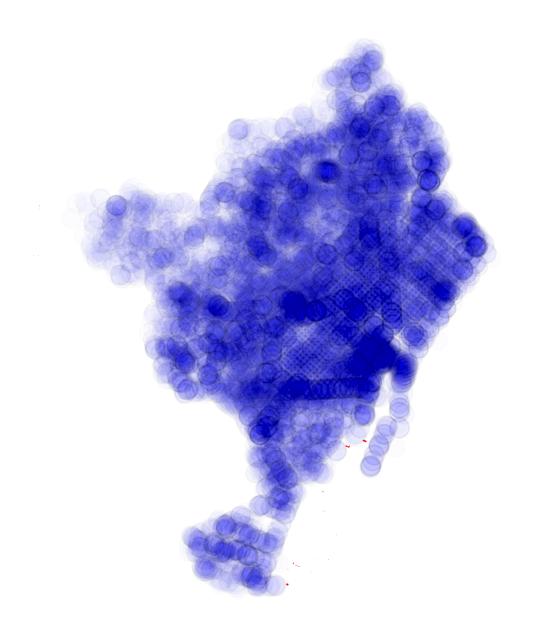

In [48]:
# Take a look at the unassigned buildings

# Filter buildings with no node assigned
unassigned_buildings = joined[joined['node_id'].isna()]

# Plot unassigned buildings
fig, ax = plt.subplots(figsize=(8, 8))

# Plot all nodes (optional, for context)
gdf_nodes.plot(ax=ax, color='blue', alpha=0.01, edgecolor='black', label='Node Buffers')

# Plot unassigned buildings
unassigned_buildings.plot(ax=ax, color='red', markersize=10, label='Unassigned Buildings')
ax.axis('off')
plt.show()

In [49]:
# Remove unassigned buildings. They are mostly portuary industrial buildings
nodes_pop = joined[~joined['node_id'].isna()].copy()
nodes_pop.drop('geometry', axis=1, inplace=True)
nodes_pop.head(2)

,node_id,building_id,census_section,f,m,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70+,population,pop_frac,people
36716,13019203.0,1310807054,0801903047,50.6,49.4,6.6,6.3,13.9,21.4,17.0,13.2,11.7,9.9,1673.0,0.012346,20.654321
5955,13019203.0,14723312,0801902149,50.6,49.4,7.6,8.0,14.6,17.9,17.0,14.5,11.3,9.2,1778.0,0.013514,24.027027


## 2.2. Compute population scores at the node level

In [50]:
demographic_cols = nodes_pop.columns.difference(['node_id', 'building_id', 'census_section', 'people'])
nodes_pop[[f"{col}_abs" for col in demographic_cols]] = nodes_pop[demographic_cols].mul(nodes_pop['people'] / 100, axis=0)
nodes_pop.drop(demographic_cols, axis=1, inplace=True)
nodes_pop['node_id'] = nodes_pop['node_id'].astype(int).copy()

nodes_pop_scores = nodes_pop.groupby(['node_id'])[['people', '0-9_abs',
       '10-19_abs', '20-29_abs', '30-39_abs', '40-49_abs', '50-59_abs',
       '60-69_abs', '70+_abs', 'f_abs', 'm_abs']].sum()

nodes_pop_scores.head(2)

,people,0-9_abs,10-19_abs,20-29_abs,30-39_abs,40-49_abs,50-59_abs,60-69_abs,70+_abs,f_abs,m_abs
node_id,,,,,,,,,,,
13019203,3739.877849,266.523129,280.294737,551.444574,726.788494,619.307541,506.775278,423.282153,365.363538,1895.607901,1844.269948
21638831,10.517986,1.146460,0.894029,1.114906,1.914273,1.756504,1.693396,1.283194,0.715223,5.090705,5.427281
